In [2]:
import numpy as np
import ast, dataIO, common_functions
from sklearn import cross_validation, linear_model, preprocessing, svm
from sklearn.grid_search import GridSearchCV
reload(dataIO)
reload(common_functions)

def get_touch_locations(userid):
    touches = []
    filenos = ["2", "6", "9"]
    
    for fileno in filenos:
        filename = "/home/dimitar/Desktop/Python/experiment/results/"+str(userid)+"_"+fileno+"up.txt"
        with open(filename, "r") as f:
            lines = f.read().splitlines()
            lines = map(lambda x: x.split('\t'), lines[1:])
            for line in lines:
                letter = line[1]
                location = ast.literal_eval(line[3])
                x = location[0]
                y = location[1]
                time = line[2]
                bod = dataIO.createlist(line[-1])
                if line[0] == "left":
                    touch = dataIO.Touch(x,y,bod,letter,time, True)
                else:
                    touch = dataIO.Touch(x,y,bod,letter,time, False)
                touches.append(touch)
        
    return touches


def run(userId):
    locations = get_touch_locations(userId)
    filtered = dataIO.filter_new(locations)
    
    centers = dataIO.get_key_centers()
    keys = centers.keys()
    
    touch_centers = []
    centers_l = []
    centers_r = []
    touches = []
    points = []
    
    points_l = []
    points_r = []
    bod_l = []
    bod_r = []
    t_l_x = []
    t_l_y = []
    t_r_x = []
    t_r_y = []
    
    for touch in filtered:
        center = centers[touch.letter]
        touch_centers.append(center)
        location = [touch.x, touch.y]        
        points.append(location)
        
        if touch.left:
            #points_l.append([touch.x, touch.y, touch.x**2, touch.y**2])
            points_l.append(location)
            centers_l.append(center)
            bod_l.append(touch.bod)
            t_l_x.append(center[0]-location[0])
            t_l_y.append(center[1]-location[1])
        else:
            #points_r.append([touch.x, touch.y, touch.x**2, touch.y**2])
            points_r.append(location)
            centers_r.append(center)
            bod_r.append(touch.bod)
            t_r_x.append(center[0]-location[0])
            t_r_y.append(center[1]-location[1])
                     
    
    centers_l = np.array(centers_l)
    centers_r = np.array(centers_r)
    touch_centers = np.array(touch_centers)
    points = np.array(points)
    points_l = np.array(points_l)
    points_r = np.array(points_r)
    bod_l = np.array(bod_l)
    bod_r = np.array(bod_r)
    t_l_x = np.array(t_l_x)
    t_l_y = np.array(t_l_y)
    t_r_x = np.array(t_r_x)
    t_r_y = np.array(t_r_y)
    
    points_unz = np.array(map(lambda x: list(x) , zip(*points))) 
    centers_unz = np.array(map(lambda x: list(x) , zip(*touch_centers)))
    
    print("MSE on x before regression: %.2f"
               % np.mean((points_unz[0] - centers_unz[0]) ** 2))
    
    print("MSE on y before regression: %.2f"
               % np.mean((points_unz[1] - centers_unz[1]) ** 2))
    print
    
    foldno = 1
    mse_x = []
    mse_y = []
    within_before = []
    within_after = []
    kf_l = cross_validation.KFold(len(points_l), n_folds=5, shuffle=True)
    kf_r = cross_validation.KFold(len(points_r), n_folds=5, shuffle=True)
    
    for left_index, right_index in zip(kf_l, kf_r):
        
        train_index_l, test_index_l = left_index[0], left_index[1]
        train_index_r, test_index_r = right_index[0], right_index[1]
        
        print
        print ("##### Fold %d #####" %foldno)
        print
        
        left_train, left_test = points_l[train_index_l], points_l[test_index_l]    
        t_l_x_train, t_l_x_test = t_l_x[train_index_l], t_l_x[test_index_l]
        t_l_y_train, t_l_y_test = t_l_y[train_index_l], t_l_y[test_index_l]
        bod_l_train, bod_l_test = bod_l[train_index_l], bod_l[test_index_l]
        
        right_train, right_test = points_r[train_index_r], points_r[test_index_r]    
        t_r_x_train, t_r_x_test = t_r_x[train_index_r], t_r_x[test_index_r]
        t_r_y_train, t_r_y_test = t_r_y[train_index_r], t_r_y[test_index_r]    
        bod_r_train, bod_r_test = bod_r[train_index_r], bod_r[test_index_r]
        
        bod_train = np.concatenate((bod_l_train, bod_r_train))
        bod_y = [0 for x in range(len(bod_l_train))] + [1 for x in range(len(bod_r_train))]
        
        scaler = preprocessing.StandardScaler().fit(bod_train)  
        bod_scaled = scaler.transform(bod_train)
        
        tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1, 0.1 ,1e-2, 1e-3, 1e-4],
                             'C': [0.001, 0.01, 0.1 ,1, 10, 100, 1000]},
                            {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1 ,1, 10, 100, 1000]}]
        
        clf = GridSearchCV(svm.SVC(C=1, cache_size=500), tuned_parameters)
        clf.fit(bod_scaled, bod_y)
        
        print clf.best_estimator_
        print
    
        regr_l_x = linear_model.LinearRegression()
        regr_l_y = linear_model.LinearRegression()
        regr_r_x = linear_model.LinearRegression()
        regr_r_y = linear_model.LinearRegression()     
        
        regr_l_x.fit(left_train, t_l_x_train)
        regr_l_y.fit(left_train, t_l_y_train)    
        regr_r_x.fit(right_train, t_r_x_train)
        regr_r_y.fit(right_train, t_r_y_train)
        
        points_test = np.concatenate((left_test, right_test))
        targets_x = np.concatenate((t_l_x_test, t_r_x_test))
        targets_y = np.concatenate((t_l_y_test, t_r_y_test))
        bod_test = np.concatenate((bod_l_test, bod_r_test))
        centers_test = np.concatenate((centers_l[test_index_l], centers_r[test_index_r]))
        
        se_x = []
        se_y = []
        corrected_points = []
        for i in range(len(points_test)):
            scaled = scaler.transform(bod_test[i])
            location = points_test[i]
            pred = clf.predict(scaled)
            
            if pred == 0:
                pred_x = regr_l_x.predict(location)
                pred_y = regr_l_y.predict(location)
            else:
                pred_x = regr_r_x.predict(location)
                pred_y = regr_r_y.predict(location)
                
            # TODO look at average error when misclassified
            # histograms?
            se_x.append((pred_x - targets_x[i])**2)
            se_y.append((pred_y - targets_y[i])**2)
            corrected_points.append([location[0]+pred_x, location[1]+pred_y])
        
        error_before = common_functions.circle_button_error(points_test, centers_test)
        error_after = common_functions.circle_button_error(corrected_points, centers_test)
        within_before.append(error_before)
        within_after.append(error_after)
            
        mse = np.mean(np.array(se_x))
        print("MSE on x: %.2f" %mse)
        mse_x.append(mse)
        
        mse = np.mean(np.array(se_y))
        print("MSE on y: %.2f" %mse)
        mse_y.append(mse)
        
        foldno +=1    
    
    within_before = np.mean(np.array(within_before), 0)
    within_after = np.mean(np.array(within_after), 0)
    
#     with open("predict.txt", "a") as myfile:
#             myfile.write(str(userId)+'\t'+str(within_after[1])+'\n')
    
    print 
    print("Mean MSE on on x: %.2f" % np.mean(mse_x))
    print("Mean MSE on on y: %.2f" % np.mean(mse_y))

run(15)

Filtered 0 points.
MSE on x before regression: 172.58
MSE on y before regression: 104.68


##### Fold 1 #####

SVC(C=1000, cache_size=500, class_weight=None, coef0=0.0, degree=3,
  gamma=0.001, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

MSE on x: 63.78
MSE on y: 90.83

##### Fold 2 #####

SVC(C=1, cache_size=500, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

MSE on x: 44.00
MSE on y: 65.97

##### Fold 3 #####

SVC(C=100, cache_size=500, class_weight=None, coef0=0.0, degree=3, gamma=0.01,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

MSE on x: 76.16
MSE on y: 110.63

##### Fold 4 #####

SVC(C=1000, cache_size=500, class_weight=None, coef0=0.0, degree=3,
  gamma=0.01, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrin

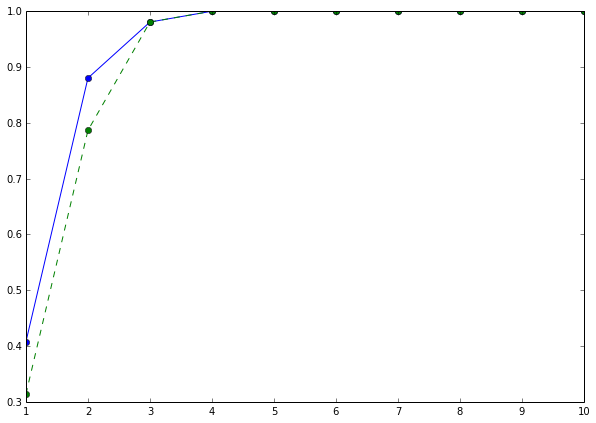

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 7))

plt.errorbar(range(1,11), within_after, marker="o")
plt.errorbar(range(1,11), within_before, linestyle="--", marker="o")

plt.show()

In [37]:
for i in range(3, 18):
    run(i)

0.792860920148
